In [3]:
import pandas as pd

In [5]:
data = pd.read_csv('https://fetch-hiring.s3.amazonaws.com/machine-learning-engineer/receipt-count-prediction/data_daily.csv')

In [8]:
data

,# Date,Receipt_Count,month
0,2021-01-01,7564766,1
1,2021-01-02,7455524,1
2,2021-01-03,7095414,1
3,2021-01-04,7666163,1
4,2021-01-05,7771289,1
...,...,...,...
360,2021-12-27,10350408,12
361,2021-12-28,10219445,12
362,2021-12-29,10313337,12
363,2021-12-30,10310644,12


<Axes: xlabel='month'>

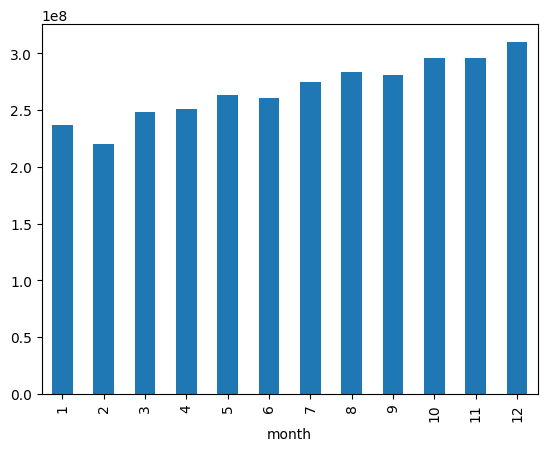

In [9]:
# plot the data for each month

data['# Date'] = pd.to_datetime(data['# Date'])
data['month'] = data['# Date'].dt.month

data.groupby('month')['Receipt_Count'].sum().plot(kind='bar')

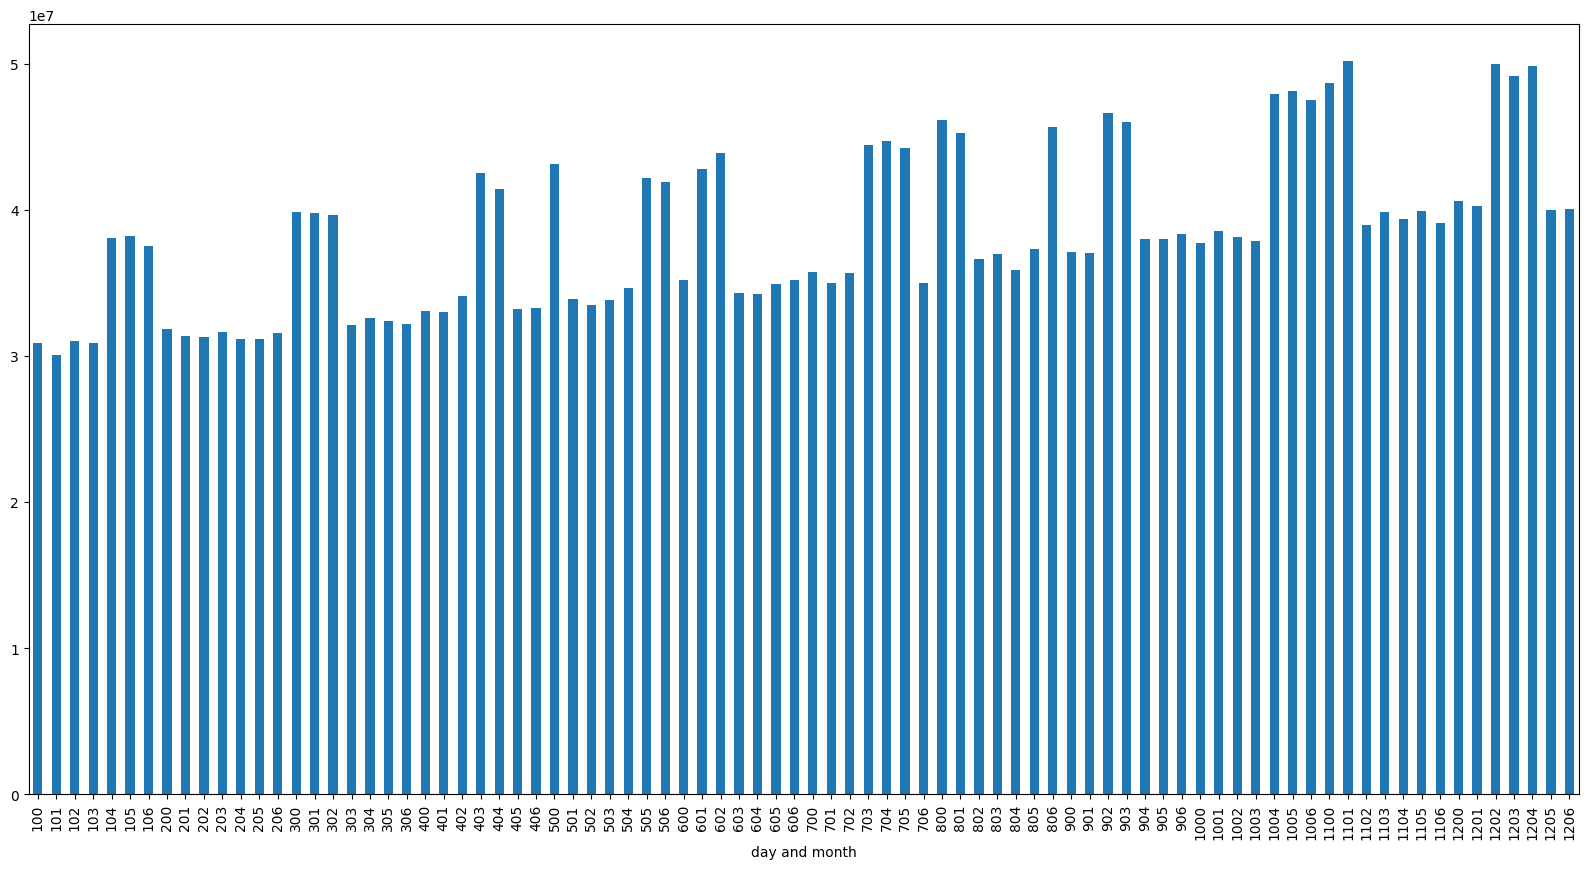

In [32]:
# plot each week days 

data['day'] = data['# Date'].dt.dayofweek
data['day and month'] = (data['month'].astype(int)*100) + data['day'].astype(int)
# do a big plot
data.groupby('day and month')['Receipt_Count'].sum().plot(kind='bar')
# increase the size of the plot
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [50]:
import torch

# store monthly values in a tensor
y = torch.tensor(data.groupby('month')['Receipt_Count'].sum().values, dtype=torch.float32)
x = torch.tensor(data.groupby('month')['Receipt_Count'].sum().index, dtype=torch.float32)

In [87]:
def do_model(degree, epochs = 10000, lr = 0.01):
    w = [torch.zeros(1, requires_grad=True) for i in range(degree)]

    b = torch.zeros(1, requires_grad=True)
    # use adam
    optimizer = torch.optim.SGD(w+[ b], lr=lr)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(epochs):
        y_hat = sum([w[i] * x ** (i + 1) for i in range(degree)]) + b
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    w_final = [w[i].item() for i in range(degree)]
    b_final = b.item()
    plt.plot(x, y, 'o')
    plt.plot(x, sum([w_final[i] * x ** (i + 1) for i in range(degree)]) + b_final)
    plt.xticks(range(1, 13))
    plt.show()

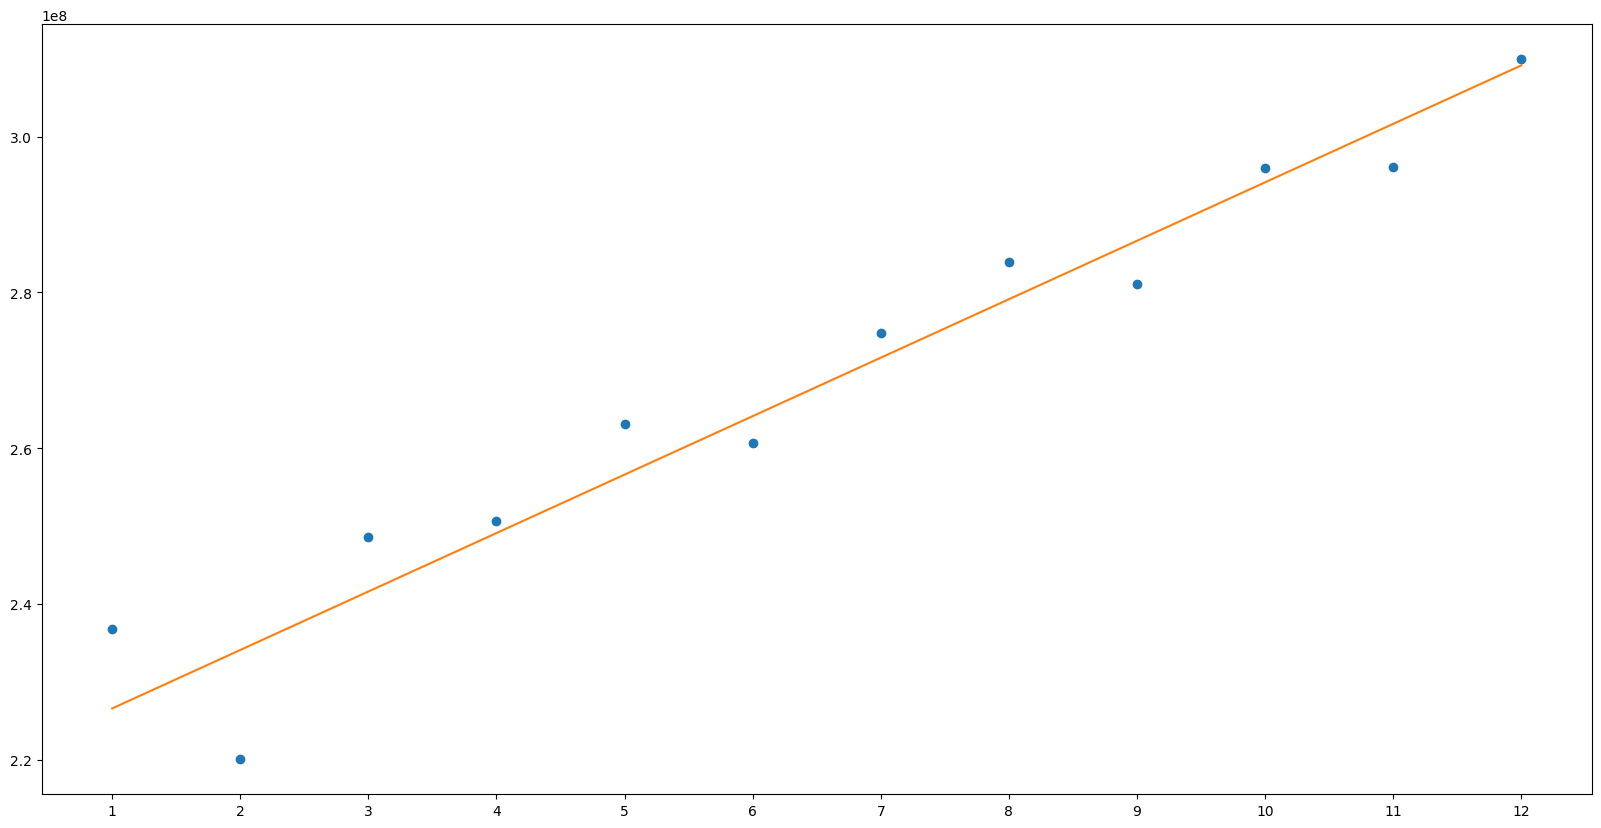

In [90]:
do_model(1, epochs=1000, lr=0.01)

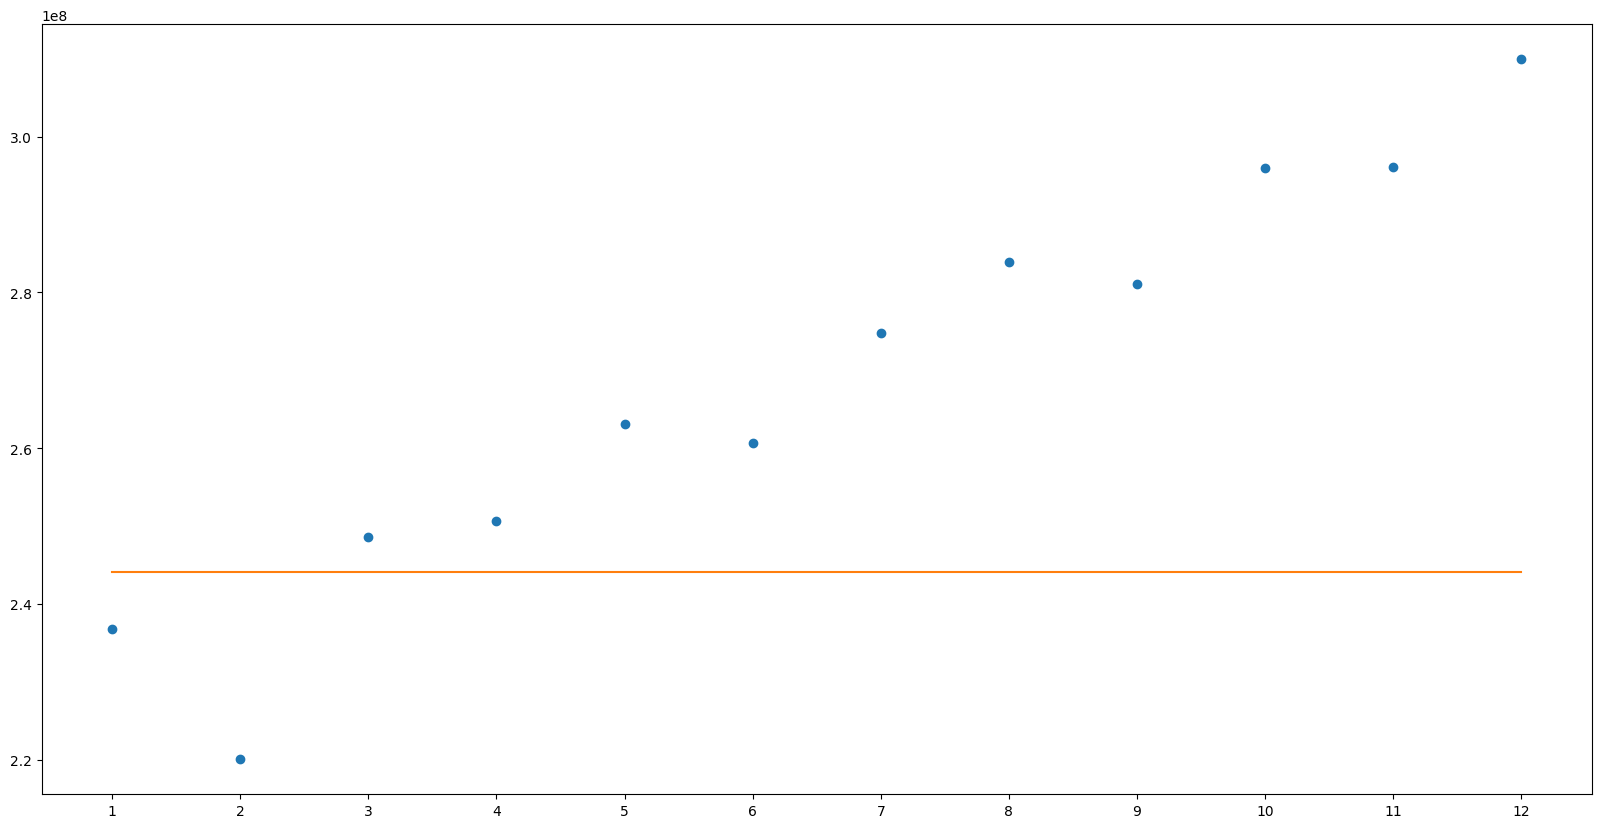

In [99]:
# try a nn
import torch.nn as nn
import torch.nn.functional as F



class Net(nn.Module):
    def __init__(self, degree):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, degree)
        self.fc2 = nn.Linear(degree, degree)
        self.fc3 = nn.Linear(degree, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
def do_model_nn(model, epochs = 10000, lr = 0.01):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    ds = torch.utils.data.TensorDataset(x, y)
    dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)

    for epoch in range(epochs):
        for x_batch, y_batch in dl:
            y_hat = model(x_batch)
            loss = loss_fn(y_hat, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    plt.plot(x, y, 'o')
    # get predictions
    predds = []
    for x_batch, y_batch in dl:
        y_hat = model(x_batch)
        predds.append(y_hat.item())
    plt.plot(x, predds)
    plt.xticks(range(1, 13))
    plt.show()

do_model_nn(Net(5), epochs=1000, lr=0.0001)

        
